In [ ]:
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
from scipy import signal as scipy_signal
import matplotlib.pyplot as plt
import pandas as pd
import os
from extract_RR_from_audio import extract_audio_from_video


## Busco la frecuencia dominante (el BIP)

Top 5 frequency peaks found:
  1. 549.99 Hz (magnitude: 1.72e+03)
  2. 549.07 Hz (magnitude: 8.64e+02)
  3. 551.97 Hz (magnitude: 8.40e+02)
  4. 548.03 Hz (magnitude: 7.99e+02)
  5. 550.98 Hz (magnitude: 7.50e+02)

Dominant frequency: 549.99 Hz


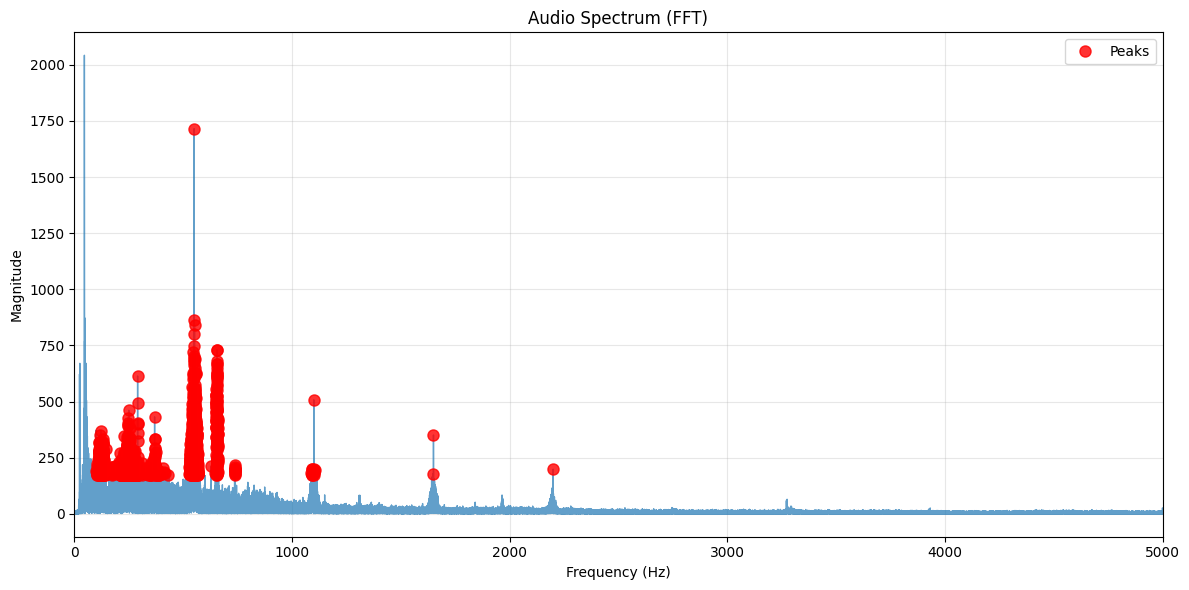

In [5]:
# Helper function to analyze audio spectrum and find the dominant periodic frequency
# Use this if you don't know the BIP frequency yet

def analyze_audio_spectrum(video_path, plot=True):
    """
    Analyze audio spectrum to find dominant periodic frequencies.
    Useful for identifying the BIP frequency.
    """
    # Extract audio
    audio_array, sample_rate = extract_audio_from_video(video_path)
    
    # Convert to mono
    if len(audio_array.shape) > 1:
        audio_array = np.mean(audio_array, axis=1)
    
    # Compute FFT
    n = len(audio_array)
    fft_vals = np.fft.fft(audio_array)
    fft_freq = np.fft.fftfreq(n, 1/sample_rate)
    
    # Get only positive frequencies
    positive_freq_idx = fft_freq > 0
    fft_freq_positive = fft_freq[positive_freq_idx]
    fft_magnitude = np.abs(fft_vals[positive_freq_idx])
    
    # Find peaks in the spectrum
    # Look for peaks above 100 Hz (typical BIPs are higher frequency)
    peaks_idx = np.array([])
    fft_freq_peaks = np.array([])
    fft_magnitude_peaks = np.array([])
    
    min_freq_idx = np.where(fft_freq_positive >= 100)[0]
    if len(min_freq_idx) > 0:
        fft_freq_peaks = fft_freq_positive[min_freq_idx[0]:]
        fft_magnitude_peaks = fft_magnitude[min_freq_idx[0]:]
        
        # Find top peaks
        peaks_idx, _ = find_peaks(fft_magnitude_peaks, height=np.max(fft_magnitude_peaks) * 0.1)
        
        if len(peaks_idx) > 0:
            # Get top 5 peaks
            peak_magnitudes = fft_magnitude_peaks[peaks_idx]
            top_5_idx = np.argsort(peak_magnitudes)[-5:][::-1]
            top_5_freqs = fft_freq_peaks[peaks_idx[top_5_idx]]
            top_5_mags = peak_magnitudes[top_5_idx]
            
            print("Top 5 frequency peaks found:")
            for i, (freq, mag) in enumerate(zip(top_5_freqs, top_5_mags)):
                print(f"  {i+1}. {freq:.2f} Hz (magnitude: {mag:.2e})")
            
            dominant_freq = top_5_freqs[0]
            print(f"\nDominant frequency: {dominant_freq:.2f} Hz")
        else:
            print("No significant peaks found in the spectrum above 100 Hz")
    
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(fft_freq_positive, fft_magnitude, linewidth=1, alpha=0.7)
        if len(peaks_idx) > 0:
            plt.plot(fft_freq_peaks[peaks_idx], fft_magnitude_peaks[peaks_idx], 
                    'ro', markersize=8, label='Peaks', alpha=0.8)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title('Audio Spectrum (FFT)')
        plt.xlim([0, min(5000, sample_rate/2)])  # Show up to 5 kHz or Nyquist
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return {
        'frequencies': fft_freq_positive,
        'magnitudes': fft_magnitude,
        'sample_rate': sample_rate
    }

# Uncomment to analyze your video's spectrum:
spectrum = analyze_audio_spectrum(video_path, plot=True)


## Filtro en 550 Hz (frecuencia encontrada) y cuento picos

In [2]:
def detect_periodic_bips(video_path, bip_frequency, bandwidth_hz=50, 
                         min_distance_seconds=0.1, plot=True):
    """
    Detect periodic BIP sounds at a specific frequency in video audio.
    
    Args:
        video_path: Path to video file
        bip_frequency: Expected frequency of the BIP sound in Hz
        bandwidth_hz: Bandwidth around the frequency for filtering (default: 50 Hz)
        min_distance_seconds: Minimum time between BIPs in seconds (default: 0.1s)
        plot: Whether to plot results
    
    Returns:
        dict with:
            - bip_times: array of time locations (seconds) where BIPs were detected
            - audio_array: original audio signal
            - filtered_audio: bandpass filtered audio
            - sample_rate: audio sample rate
    """
    # Extract audio from video
    print(f"Extracting audio from: {video_path}")
    audio_array, sample_rate = extract_audio_from_video(video_path)
    
    # Convert to mono if needed
    if len(audio_array.shape) > 1:
        audio_array = np.mean(audio_array, axis=1)
    
    # Calculate time axis
    duration = len(audio_array) / sample_rate
    time_axis = np.arange(len(audio_array)) / sample_rate
    
    print(f"Audio duration: {duration:.2f} seconds")
    print(f"Sample rate: {sample_rate} Hz")
    
    # Design bandpass filter around the BIP frequency
    nyquist = sample_rate / 2
    low_cutoff = max(20, bip_frequency - bandwidth_hz / 2)
    high_cutoff = min(nyquist - 1, bip_frequency + bandwidth_hz / 2)
    
    low_norm = low_cutoff / nyquist
    high_norm = high_cutoff / nyquist
    
    # Ensure valid filter range
    low_norm = max(0.001, min(0.999, low_norm))
    high_norm = max(0.001, min(0.999, high_norm))
    
    if low_norm >= high_norm:
        raise ValueError(f"Invalid filter range: {low_cutoff}-{high_cutoff} Hz")
    
    print(f"Applying bandpass filter: {low_cutoff:.1f} - {high_cutoff:.1f} Hz")
    
    # Create bandpass filter (4th order Butterworth)
    b, a = butter(4, [low_norm, high_norm], btype='band')
    filtered_audio = filtfilt(b, a, audio_array)
    
    # Calculate envelope of filtered signal
    envelope = np.abs(filtered_audio)
    
    # Smooth the envelope slightly (10ms window)
    from scipy.ndimage import uniform_filter1d
    window_size = int(sample_rate * 0.01)  # 10ms
    if window_size < 1:
        window_size = 1
    envelope_smooth = uniform_filter1d(envelope, size=window_size)
    
    # Find peaks in the envelope
    # Minimum distance between peaks (in samples)
    min_distance_samples = int(sample_rate * min_distance_seconds)
    
    # Auto-threshold: mean + 2*std (adjustable)
    threshold = np.mean(envelope_smooth) + 2 * np.std(envelope_smooth)
    
    print(f"Peak detection threshold: {threshold:.6f}")
    print(f"Minimum distance between BIPs: {min_distance_seconds:.3f} seconds")
    
    # Find peaks
    peaks_idx, peak_properties = find_peaks(
        envelope_smooth,
        height=threshold,
        distance=min_distance_samples
    )
    
    # Convert peak indices to time
    bip_times = peaks_idx / sample_rate
    
    print(f"\nDetected {len(bip_times)} BIPs")
    if len(bip_times) > 0:
        print(f"First BIP at: {bip_times[0]:.3f} seconds")
        print(f"Last BIP at: {bip_times[-1]:.3f} seconds")
        if len(bip_times) > 1:
            avg_interval = np.mean(np.diff(bip_times))
            print(f"Average interval: {avg_interval:.3f} seconds ({1/avg_interval:.2f} Hz)")
    
    # Plot results
    if plot and len(bip_times) > 0:
        fig, axes = plt.subplots(3, 1, figsize=(15, 10))
        
        # Plot 1: Original audio signal
        axes[0].plot(time_axis, audio_array, linewidth=0.5, alpha=0.7, color='blue')
        axes[0].set_xlabel('Time (s)')
        axes[0].set_ylabel('Amplitude')
        axes[0].set_title('Original Audio Signal')
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Filtered signal with detected BIPs
        axes[1].plot(time_axis, filtered_audio, linewidth=0.5, alpha=0.7, color='green', label='Filtered')
        axes[1].plot(bip_times, filtered_audio[peaks_idx], 'ro', markersize=8, 
                     label=f'Detected BIPs ({len(bip_times)})', alpha=0.8)
        axes[1].set_xlabel('Time (s)')
        axes[1].set_ylabel('Amplitude')
        axes[1].set_title(f'Bandpass Filtered Signal ({low_cutoff:.1f}-{high_cutoff:.1f} Hz)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Plot 3: Envelope with peaks
        axes[2].plot(time_axis, envelope_smooth, linewidth=1, color='orange', label='Envelope')
        axes[2].axhline(y=threshold, color='red', linestyle='--', linewidth=1, label='Threshold')
        axes[2].plot(bip_times, envelope_smooth[peaks_idx], 'ro', markersize=8, 
                     label=f'Detected BIPs ({len(bip_times)})', alpha=0.8)
        axes[2].set_xlabel('Time (s)')
        axes[2].set_ylabel('Amplitude')
        axes[2].set_title('Envelope Detection')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return {
        'bip_times': bip_times,
        'audio_array': audio_array,
        'filtered_audio': filtered_audio,
        'sample_rate': sample_rate,
        'peak_indices': peaks_idx,
        'threshold': threshold,
        'filter_range': (low_cutoff, high_cutoff)
    }


Extracting audio from: videos_iPPG_paula/20241206_104904.mp4
Audio duration: 83.54 seconds
Sample rate: 48000 Hz
Applying bandpass filter: 525.0 - 575.0 Hz
Peak detection threshold: 0.006033
Minimum distance between BIPs: 0.100 seconds

Detected 85 BIPs
First BIP at: 0.854 seconds
Last BIP at: 82.695 seconds
Average interval: 0.974 seconds (1.03 Hz)


C:\Users\pedro\AppData\Local\Temp\ipykernel_16876\4016260035.py:126: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\pedro\edge-rppg-health\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


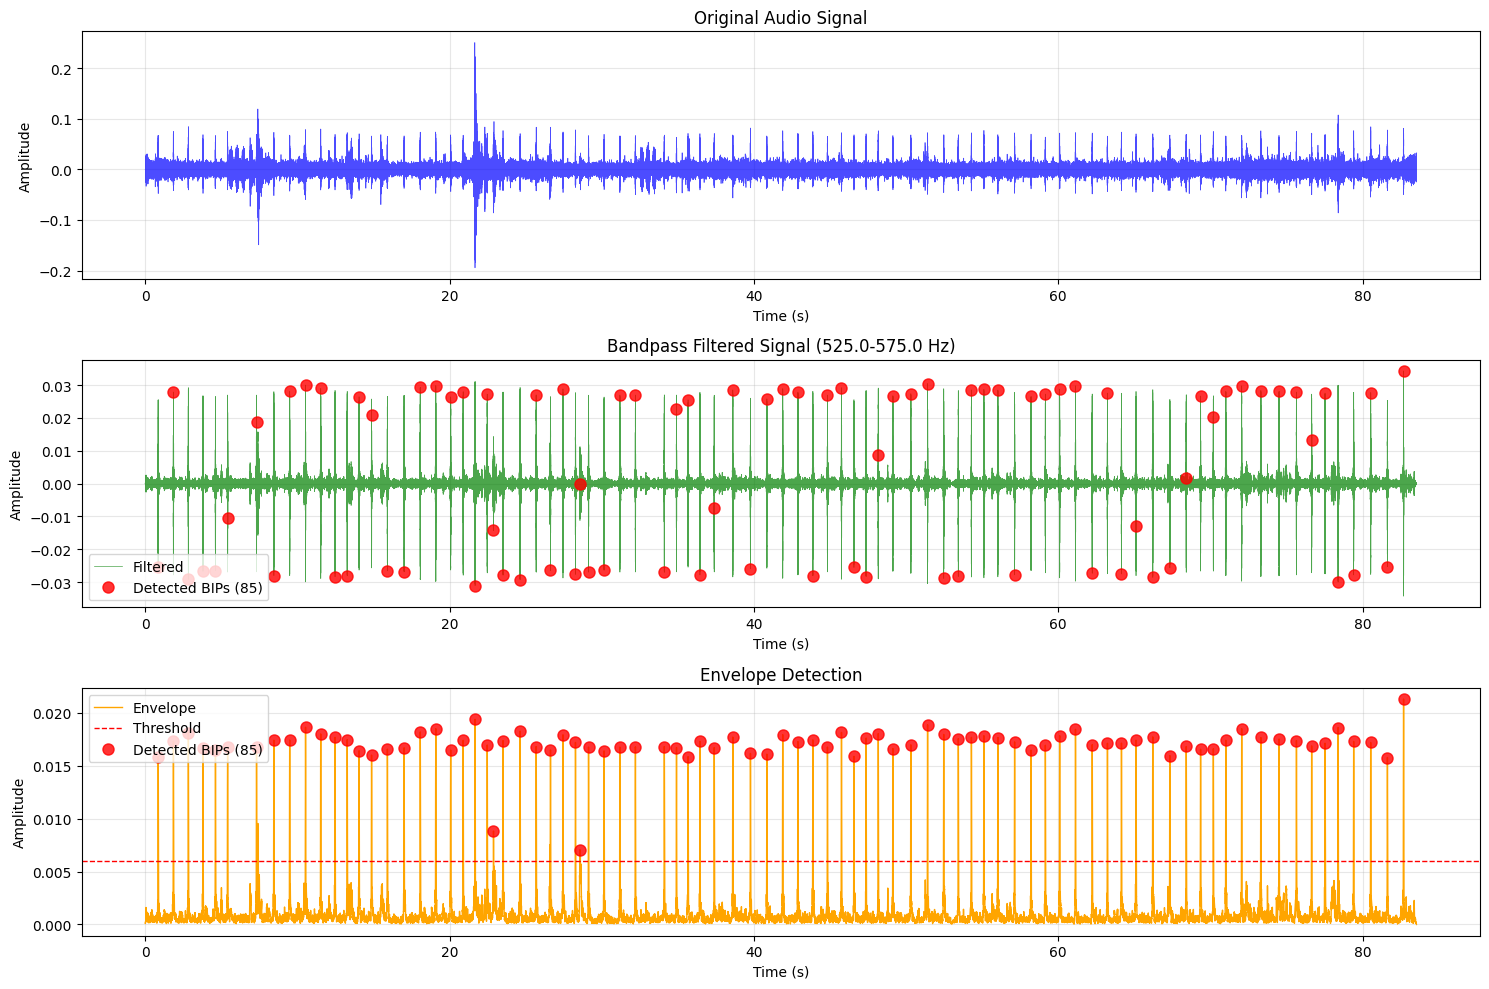


BIP time locations (seconds):
[ 0.85358333  1.854625    2.835375    3.79539583  4.61547917  5.41502083
  7.3144375   8.45558333  9.49477083 10.536375   11.53454167 12.4755
 13.2755625  14.05466667 14.87477083 15.91554167 17.0138125  18.07472917
 19.09479167 20.07470833 20.89664583 21.6791875  22.47666667 22.88835417
 23.515625   24.6356875  25.69472917 26.63383333 27.45477083 28.275625
 28.57075    29.1338125  30.15389583 31.19477083 32.21491667 34.1135625
 34.91458333 35.67504167 36.45579167 37.39533333 38.61491667 39.7740625
 40.854875   41.894875   42.89485417 43.87589583 44.83485417 45.75675
 46.57595833 47.37579167 48.17522917 49.13485417 50.31502083 51.41489583
 52.47583333 53.4358125  54.29495833 55.1150625  56.03491667 57.13397917
 58.21497917 59.15495833 60.094875   61.13491667 62.23583333 63.23491667
 64.15589583 65.11377083 66.21408333 67.33585417 68.41452083 69.35504167
 70.1948125  71.01502083 72.0574375  73.316875   74.51520833 75.65510417
 76.6548125  77.53502083 78.394

In [6]:
# Example usage:
# Replace 'your_video.mp4' with your video path and set the BIP frequency

video_path = "videos_iPPG_paula/20241206_104904.mp4"  # Change this to your video
bip_frequency = 550  # Change this to your BIP frequency in Hz (e.g., 1000 Hz = 1 kHz)

# Optional parameters:
# bandwidth_hz: How wide the filter should be around the frequency (default: 50 Hz)
# min_distance_seconds: Minimum time between BIPs (default: 0.1 seconds)

result = detect_periodic_bips(
    video_path=video_path,
    bip_frequency=bip_frequency,
    bandwidth_hz=50,  # Adjust if needed
    min_distance_seconds=0.1,  # Adjust if BIPs are very close together
    plot=True
)

# Access the time locations
bip_times = result['bip_times']
print(f"\nBIP time locations (seconds):")
print(bip_times)


## Calculo HR y analizo la señal

In [10]:
# Calculate HR from BIP count and median RR interval
# Also get ground truth HR from Excel file
import os
import pandas as pd

# Get ground truth HR from Excel file
excel_gt_path = os.path.join("videos_iPPG_paula", "Metadata videos iPPG.xlsx")
gt_hr = None

try:
    # Read Excel file (same way as main_paula.py)
    df = pd.read_excel(excel_gt_path, skiprows=1)
    df.columns = ['Empty', 'Archivo', 'Celu', 'Promedio', 'Condiciones']
    
    # Drop the empty column if it exists
    if 'Empty' in df.columns:
        df = df.drop(columns=['Empty'])
    
    # Extract filename from video_path (handle both full path and just filename)
    video_filename = os.path.basename(video_path)
    # Remove extension for matching
    video_filename_no_ext = os.path.splitext(video_filename)[0]
    
    # Search for matching row in Excel
    for idx, row in df.iterrows():
        file_name = str(row["Archivo"]).strip()
        file_name_no_ext = os.path.splitext(file_name)[0] if file_name else ""
        
        # Try to match by filename (with or without extension)
        if (file_name == video_filename or 
            file_name_no_ext == video_filename_no_ext or
            video_filename_no_ext in file_name or
            file_name in video_filename_no_ext):
            
            # Get ground truth HR
            try:
                gt_hr = float(row["Promedio"]) if not pd.isna(row["Promedio"]) else None
                print(f"Found GT HR in Excel: {gt_hr:.2f} BPM (from row with file: {file_name})")
                break
            except Exception:
                gt_hr = None
    
    if gt_hr is None:
        print(f"Warning: Could not find GT HR for video '{video_filename}' in Excel file")
        print(f"Available files in Excel: {df['Archivo'].tolist()}")
        
except Exception as e:
    print(f"Warning: Could not read Excel file: {e}")
    gt_hr = None

# Calculate HR from BIP count and median RR interval
if len(bip_times) > 1:
    # Calculate time period (from first to last BIP)
    time_period = bip_times[-1] - bip_times[0]
    
    # Calculate HR from number of BIPs over time period
    # HR = (number of BIPs / time_period) * 60 (to convert to BPM)
    n_bips = len(bip_times)
    hr_from_count = (n_bips / time_period) * 60
    
    # Calculate RR intervals (time between consecutive BIPs)
    rr_intervals = np.diff(bip_times)
    
    # Calculate median RR interval
    median_rr = np.median(rr_intervals)
    
    # Calculate HR from median RR interval
    # HR = 60 / RR_interval (in seconds)
    hr_from_rr = 60.0 / median_rr
    
    # Calculate mean RR interval for comparison
    mean_rr = np.mean(rr_intervals)
    hr_from_mean_rr = 60.0 / mean_rr
    
    print("\n" + "=" * 70)
    print("HEART RATE AND RR INTERVAL ANALYSIS")
    print("=" * 70)
    print(f"Number of BIPs detected: {n_bips}")
    print(f"Time period: {time_period:.2f} seconds ({time_period/60:.2f} minutes)")
    print(f"\nHR from BIP count: {hr_from_count:.2f} BPM")
    print(f"HR from median RR: {hr_from_rr:.2f} BPM")
    print(f"HR from mean RR: {hr_from_mean_rr:.2f} BPM")
    
    if gt_hr is not None:
        print(f"\nGround Truth HR (from Excel): {gt_hr:.2f} BPM")
        print(f"\nError comparison:")
        print(f"  Error (HR from count): {abs(hr_from_count - gt_hr):.2f} BPM")
        print(f"  Error (HR from median RR): {abs(hr_from_rr - gt_hr):.2f} BPM")
        print(f"  Error (HR from mean RR): {abs(hr_from_mean_rr - gt_hr):.2f} BPM")
    
    print(f"\nMedian RR interval: {median_rr:.3f} seconds")
    print(f"Mean RR interval: {mean_rr:.3f} seconds")
    print(f"Std RR interval: {np.std(rr_intervals):.3f} seconds")
    print(f"Min RR interval: {np.min(rr_intervals):.3f} seconds")
    print(f"Max RR interval: {np.max(rr_intervals):.3f} seconds")
else:
    print("Not enough BIPs detected to calculate HR and RR intervals (need at least 2)")


Found GT HR in Excel: 62.00 BPM (from row with file: 20241206_104904)

HEART RATE AND RR INTERVAL ANALYSIS
Number of BIPs detected: 85
Time period: 81.84 seconds (1.36 minutes)

HR from BIP count: 62.32 BPM
HR from median RR: 61.17 BPM
HR from mean RR: 61.58 BPM

Ground Truth HR (from Excel): 62.00 BPM

Error comparison:
  Error (HR from count): 0.32 BPM
  Error (HR from median RR): 0.83 BPM
  Error (HR from mean RR): 0.42 BPM

Median RR interval: 0.981 seconds
Mean RR interval: 0.974 seconds
Std RR interval: 0.217 seconds
Min RR interval: 0.295 seconds
Max RR interval: 1.899 seconds
